# Trend Convexity

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_process import ArmaProcess

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
src_path = os.path.join(parent_path, "src")
hf_path = os.path.join(data_path, "hf_indices.parquet")
spx_path = os.path.join(data_path, "spx.parquet")
futures_path = os.path.join(data_path, "futures.parquet")

# Read in data

Text(0.5, 0.98, 'Cumulative Returns of Trend Following Hedge Fund Indices')

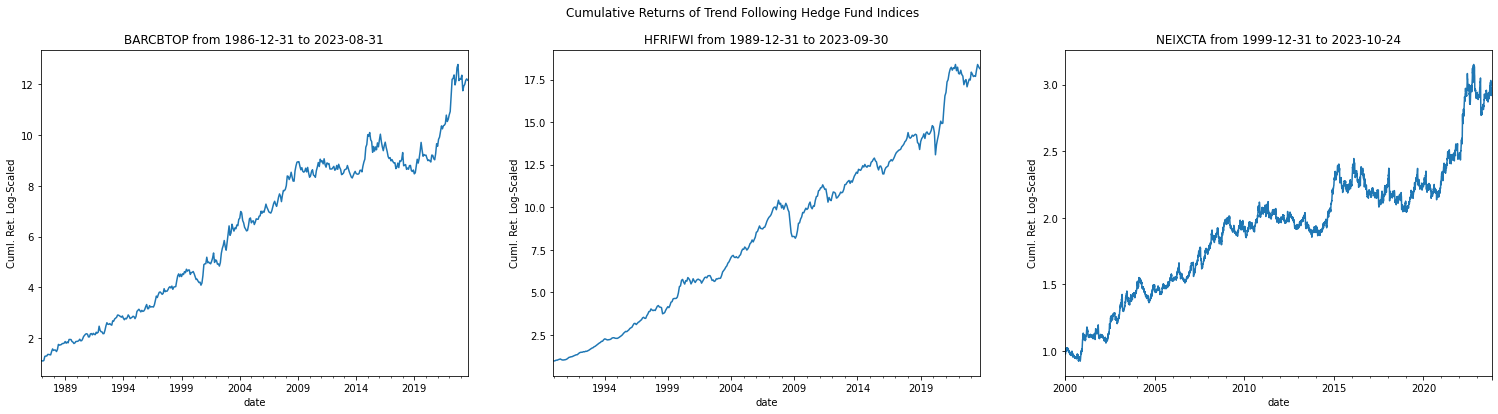

In [3]:
df_hf = (pd.read_parquet(
    path = hf_path, engine = "pyarrow").
    assign(security = lambda x: x.security.str.split(" ").str[0]))

tickers = df_hf.security.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(tickers), figsize = (26,6))

for i, ticker in enumerate(tickers):
    
    df_tmp = (df_hf.query(
        "security == @ticker").
        drop(columns = ["security"]).
        set_index("date").
        rename(columns = {"PX_LAST": ticker}).
        pct_change().
        apply(lambda x: np.cumprod(1 + x)))
    
    (df_tmp.plot(
        ax = axes[i],
        legend = False,
        ylabel = "Cuml. Ret. Log-Scaled",
        title = "{} from {} to {}".format(
            ticker, 
            df_tmp.index.min().date(),
            df_tmp.index.max().date())))
    
fig.suptitle("Cumulative Returns of Trend Following Hedge Fund Indices")

# Introduction

Hedge funds incur negative convexity to market returns. Below is a regression of the hedge fund returns relative to the market

In [4]:
def _pct_change(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "date").
        assign(
            index_rtn = lambda x: x.PX_LAST.pct_change(),
            spx_rtn = lambda x: x.SPX.pct_change()))

df_hf_monthly = (df_hf.query(
    "security != 'NEIXCTA'").
    assign(month_year = lambda x: x.date.dt.month.astype(str) + "-" + x.date.dt.year.astype(str)).
    drop(columns = ["date"]))

df_spx_monthly = (df_spx.query(
    "security == 'SPX'").
    set_index("date").
    drop(columns = ["security"]).
    resample("M").
    last().
    reset_index().
    assign(month_year = lambda x: x.date.dt.month.astype(str) + "-" + x.date.dt.year.astype(str)).
    drop(columns = ["date"]).
    rename(columns = {"PX_LAST": "SPX"}))

df_rtn = (df_hf_monthly.merge(
    right = df_spx_monthly, how = "inner", on = ["month_year"]).
    assign(date = lambda x: pd.to_datetime(x.month_year)).
    drop(columns = "month_year").
    groupby("security").
    apply(_pct_change).
    dropna())

NameError: name 'df_spx' is not defined

Starting with the HF Equal Weight Return

In [ ]:
fig, axes = plt.subplots(figsize = (12,6))

df_hfrifwi = (df_rtn.query(
    "security == 'HFRIFWI'").
    assign(
        spx_rtn = lambda x: x.spx_rtn * 100,
        index_rtn = lambda x: x.index_rtn * 100))

poly_model = np.poly1d(np.polyfit(
    x = df_hfrifwi.spx_rtn,
    y = df_hfrifwi.index_rtn,
    deg = 2))

x = np.linspace(start = df_hfrifwi.spx_rtn.min(), stop = df_hfrifwi.spx_rtn.max(), num = 2_000)
y = poly_model(x)
                          
(df_hfrifwi.plot(
    kind = "scatter", x = "spx_rtn", y = "index_rtn",
    ylabel = "HFRIFWI Index (%)",
    xlabel = "SPX (%)",
    ax = axes,
    title = "Hedge Fund Weighted Composite Index (Monthly) Returns from {} to {}".format(
        df_hfrifwi.date.min().date(),
        df_hfrifwi.date.max().date())))

axes.plot(x, y, color = "r")

plt.show()

Trend followers on the other hand have positive convexity to the market. 

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize = (26,6))

df_sg = (pd.concat(
    [df_hf.query("security == 'NEIXCTA'"), df_spx.query("security == 'SPX'")]).
    pivot(index = "date", columns = "security", values = "PX_LAST").
    resample("M").
    first().
    pct_change().
    dropna() * 
    100)

poly_model = np.poly1d(np.polyfit(
    x = df_sg.SPX,
    y = df_sg.NEIXCTA,
    deg = 2))

x = np.linspace(start = df_sg.SPX.min(), stop = df_sg.SPX.max(), num = 2_000)
y = poly_model(x)

(df_sg.plot(
    ax = axes[0],
    kind = "scatter",
    x = "SPX", y = "NEIXCTA",
    xlabel = "SPX (%)",
    ylabel = "SG CTA (%)",
    title = "SG CTA Index vs. SPX Monthly Returns from {} to {}".format(
        df_sg.index.min().date(),
        df_sg.index.max().date())))

axes[0].plot(x,y, color = "r")

df_barcbtop = df_rtn.query("security == 'BARCBTOP'").set_index("date") * 100

poly_model = np.poly1d(np.polyfit(
    x = df_barcbtop.spx_rtn,
    y = df_barcbtop.index_rtn,
    deg = 2))

x = np.linspace(start = df_barcbtop.spx_rtn.min(), stop = df_barcbtop.spx_rtn.max(), num = 2_000)
y = poly_model(x)
               
(df_barcbtop.plot(
    kind = "scatter",
    ax = axes[1],
    x = "spx_rtn", y = "index_rtn",
    xlabel = "SPX (%)",
    ylabel = "BTOP 50 (%)",
    title = "BTOP50 vs. SPX Monthly Returns from {} to {}".format(
        df_barcbtop.index.min().date(),
        df_barcbtop.index.max().date())))

axes[1].plot(x,y, color = "r")
fig.suptitle("Trend Follower Returns vs. Market Returns")
plt.show()

In [ ]:
df_spx_tmp = (df_spx
             .query("security == 'SPX'")
             .drop(columns = ["security"]))

def _get_ols(df: pd.DataFrame):
    
    model = (sm.OLS(
        endog = df.hf_rtn,
        exog  = sm.add_constant(df[["spx_rtn", "squared_rtn"]])).
        fit())
    
    return model

models = (df_hf.pivot(
    index = "date", columns = "security", values = "PX_LAST").
    merge(right = df_spx_tmp, how = "inner", on = ["date"]).
    set_index("date").
    resample("1M").
    first().
    pct_change().
    assign(squared_rtn = lambda x: x.PX_LAST ** 2).
    rename(columns = {"PX_LAST": "spx_rtn"}).
    reset_index().
    melt(id_vars = ["date", "spx_rtn", "squared_rtn"], var_name = "hf_index", value_name = "hf_rtn").
    dropna().
    set_index("date").
    groupby("hf_index").
    apply(_get_ols).
    to_dict())

df_ols_params = (pd.concat([
    (pd.merge(
        left  = models[model_name].params.to_frame(name = "param_val").reset_index(),
        right = models[model_name].tvalues.to_frame(name = "t_value").reset_index(),
        how   = "inner",
        on    = ["index"]).
        merge(right = models[model_name].pvalues.to_frame(name = "p_value").reset_index()).
        assign(hf_index = model_name))
    for model_name in models.keys()]).
    set_index(["hf_index", "index"]).
    apply(lambda x: np.round(x,4)).
    reset_index()
    [["hf_index", "index", "param_val", "t_value", "p_value"]])

display(df_ols_params.rename(
    columns = {
        "hf_index": "HF Index",
        "index"   : "parameter"}))

In [ ]:
(df_ols_params.query(
    "index == 'squared_rtn'").
    set_index("hf_index")
    [["param_val"]].
    sort_values("param_val").
    plot(
        figsize = (12,6),
        kind    = "bar",
        rot     = 0,
        xlabel  = "HF Index",
        ylabel  = r"$\beta \cdot SPX^2$",
        legend  = False,
        title   = r"$\beta$ of Hedge Fund Returns for SPX squared returns controlling for returns"))